from Github to Colaboratory:<br>
https://github.com/simoninithomas/cifar-10-classifier-pytorch/blob/master/PyTorch%20Cifar-10%20Classifier.ipynb<br>to<br>
https://colab.research.google.com/github/simoninithomas/cifar-10-classifier-pytorch/blob/master/PyTorch%20Cifar-10%20Classifier.ipynb


# PyTorch Cifar-10 Classifier

🏆: Train a CNN that **correctly classify cifar-10 images**
<br>
<img src="https://www.researchgate.net/publication/322148855/figure/fig1/AS:577424834662400@1514680216761/Heterogeneousness-and-diversity-of-the-CIFAR-10-entries-in-their-10-image-categories-The.png" style="width:40%; height:40%"/>

## Step 0: Import the libraries 📚

In [1]:
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
#DataRoaderに対し、部分分割するために使用する
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Testing if we have CUDA (hence GPU) 🖥️

In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
   
if train_on_gpu:
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

CUDA is available! Training on GPU...


## Step 2: Load the data 📦

- Download the data.
- Load training and test data.
- Preprocessing and data augmentation
- Split training data into training and validation.　訓練データを訓練用と検証用に分ける。
- Create DataLoaders for each of these sets of data.

In [3]:
# Number of subprocesses to use for data loading
num_workers = 0

# How many samples per batch to load
batch_size = 20

# Percentage of training set to use as validation　検証データの割合。
n_valid = 0.2

# Convert data to a normalized torch.FloatTensor
# Data augmentation
transform = transforms.Compose([
    #ランダムに左右逆転                                
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    #ランダムに10度方向け
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #RGBすべての色の発色が均等になるようにする
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Select training_set and testing_set
train_data = datasets.CIFAR10("data", 
                              train= True,
                             download=True,
                             transform = transform)

test_data = datasets.CIFAR10("data", 
                              train= False,
                             download=True,
                             transform = transform)

# Get indices for training_set and validation_set
#訓練データのうち、検証データの割合が20%となるようインデックスを決める。
n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
#訓練データのうち20%を検証データとして取り出すサンプラーを定義。
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
#訓練用、検証用、テスト用バッチデータローダー
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                          sampler = train_sampler, #sampler を採用
                                          num_workers = num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                          sampler = valid_sampler, #sampler を採用
                                          num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size = batch_size,
                                          num_workers = num_workers)

# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualize a batch of training data

In [4]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    #すべての色が0.5以上。つまり薄くなる。
    img = img / 2 + 0.5 # 全ての色を明るくする。　元々明るい→明るいまま　暗い→明るく。0.5以上に。
    # Convert from tensor image
    #テンソルイメージをnumpyイメージに変換。[channel, width, height]?
    plt.imshow(np.transpose(img, (1,2,0)))

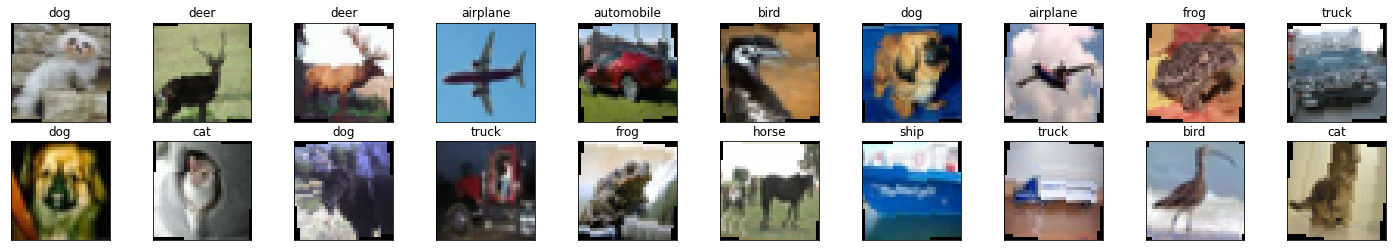

In [5]:
# Get one batch of training images
#iterによって１バッチ分取り出す。
dataiter = iter(train_loader)
images, labels = dataiter.next()
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

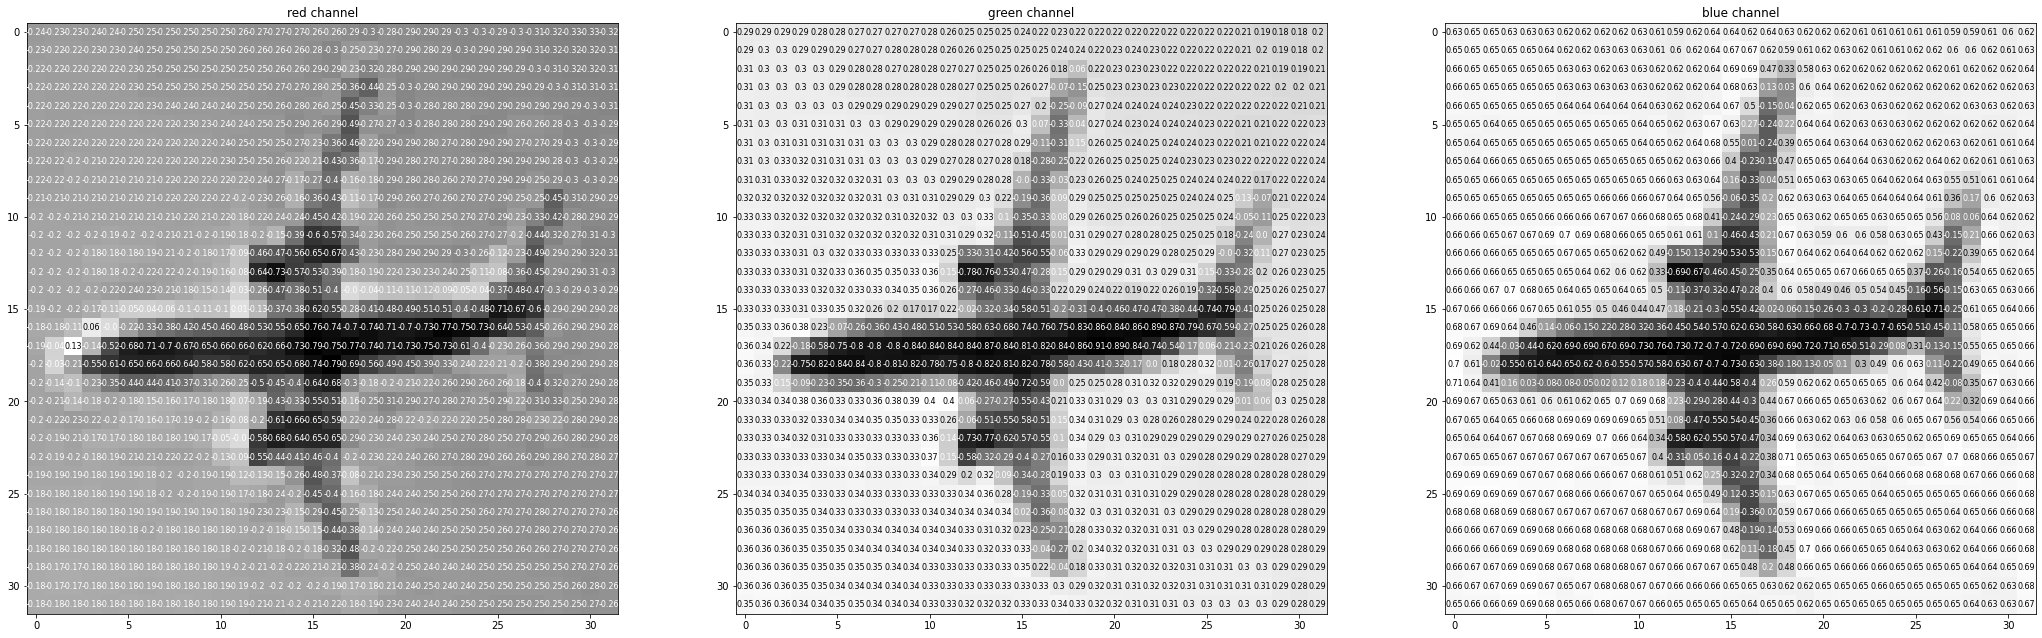

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

### Step 3: Define the CNN architecture 🧠
The more convolutional layers you include, **the more complex patterns in color and shape a model can detect.**

モデル実験
<pre>
Model	Acc.
VGG16	92.64%
ResNet18	93.02%
ResNet50	93.62%
ResNet101	93.75%
RegNetX_200MF	94.24%
RegNetY_400MF	94.29%
MobileNetV2	94.43%
ResNeXt29(32x4d)	94.73%
ResNeXt29(2x64d)	94.82%
DenseNet121	95.04%
PreActResNet18	95.11%
DPN92	95.16%
</pre>

In [7]:
!git clone https://github.com/kuangliu/pytorch-cifar.git pytorch-cifar2
%cd pytorch-cifar2/
!mv models ../
%cd ..
from models import *

Cloning into 'pytorch-cifar2'...
remote: Enumerating objects: 330, done.
remote: Total 330 (delta 0), reused 0 (delta 0), pack-reused 330
Receiving objects: 100% (330/330), 74.58 KiB | 261.00 KiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/pytorch-cifar2
/content


In [8]:
!ls

data  models  pytorch-cifar2  sample_data


In [9]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        
        # Convolutional layers
                            #Init_channels, channels, kernel_size, padding) 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 細かくみていく 
        
        # Pooling layers
        #kernel-size=2, stride=2
        self.pool = nn.MaxPool2d(2,2) # convolution　細かく poolingは大まかに
        
        # FC layers
        # Linear layer (64x4x4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        
        # Linear Layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        #ELU(x)=max(0,x)+min(0,α∗(exp(x)−1))
        #ReLU関数、ただし負領域では-α（デフォルト -1.0)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x))) # elu: lump関数
        
        
        # Flatten the image
        x = x.view(-1, 64*4*4) #64*4*4の大きさに変換
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# model = CNNNet()
# model = RegNetX_200MF()
# model = DPN92()
# model = VGG16()
model = ResNet18()
print(model)

# Move tensors to GPU is CUDA is available
if train_on_gpu:
    model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

### Step 4: Specify Loss function and optimizer

In [10]:
# Specify the Loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Step 5: Train the network
If the validation loss ever increases it means overfitting

In [11]:
# number of epochs to train the model
n_epochs = 25 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.111527 	Validation Loss: 0.211301
Validation loss decreased (inf --> 0.211301).  Saving model ...
Epoch: 2 	Training Loss: 0.749935 	Validation Loss: 0.157827
Validation loss decreased (0.211301 --> 0.157827).  Saving model ...
Epoch: 3 	Training Loss: 0.597415 	Validation Loss: 0.147079
Validation loss decreased (0.157827 --> 0.147079).  Saving model ...
Epoch: 4 	Training Loss: 0.512750 	Validation Loss: 0.136751
Validation loss decreased (0.147079 --> 0.136751).  Saving model ...
Epoch: 5 	Training Loss: 0.453649 	Validation Loss: 0.115787
Validation loss decreased (0.136751 --> 0.115787).  Saving model ...
Epoch: 6 	Training Loss: 0.404413 	Validation Loss: 0.109900
Validation loss decreased (0.115787 --> 0.109900).  Saving model ...
Epoch: 7 	Training Loss: 0.364771 	Validation Loss: 0.103146
Validation loss decreased (0.109900 --> 0.103146).  Saving model ...
Epoch: 8 	Training Loss: 0.328252 	Validation Loss: 0.102441
Validation loss decreased (0.10314

In [12]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [13]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.513258

Test Accuracy of airplane: 90% (907/1000)
Test Accuracy of automobile: 94% (941/1000)
Test Accuracy of  bird: 71% (718/1000)
Test Accuracy of   cat: 73% (732/1000)
Test Accuracy of  deer: 86% (869/1000)
Test Accuracy of   dog: 76% (763/1000)
Test Accuracy of  frog: 89% (893/1000)
Test Accuracy of horse: 82% (825/1000)
Test Accuracy of  ship: 90% (904/1000)
Test Accuracy of truck: 88% (887/1000)

Test Accuracy (Overall): 84% (8439/10000)


<pre>
-- 自作モデル
Test Loss: 0.716668

Test Accuracy of airplane: 78% (788/1000)
Test Accuracy of automobile: 91% (913/1000)
Test Accuracy of  bird: 65% (656/1000)
Test Accuracy of   cat: 52% (526/1000)
Test Accuracy of  deer: 66% (666/1000)
Test Accuracy of   dog: 63% (636/1000)
Test Accuracy of  frog: 88% (885/1000)
Test Accuracy of horse: 79% (796/1000)
Test Accuracy of  ship: 84% (840/1000)
Test Accuracy of truck: 77% (772/1000)

Test Accuracy (Overall): 74% (7478/10000)
</pre>

<pre>
-- RegNetX_200MF
Test Loss: 0.504768

Test Accuracy of airplane: 88% (887/1000)
Test Accuracy of automobile: 94% (945/1000)
Test Accuracy of  bird: 75% (756/1000)
Test Accuracy of   cat: 71% (710/1000)
Test Accuracy of  deer: 79% (795/1000)
Test Accuracy of   dog: 68% (682/1000)
Test Accuracy of  frog: 88% (885/1000)
Test Accuracy of horse: 90% (905/1000)
Test Accuracy of  ship: 92% (920/1000)
Test Accuracy of truck: 89% (893/1000)

Test Accuracy (Overall): 83% (8378/10000)
</pre>

In [14]:
import torch
array = torch.zeros(4) #長さ4の配列を定義（これはcpu配列です）
print(array)
#結果は tensor([0., 0., 0., 0.]) と表示されるはず

array_gpu = array.cuda()
print(array_gpu)
#結果は tensor([0., 0., 0., 0.], device='cuda:0') と表示されるはず

tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.], device='cuda:0')


# 課題
<pre>
--- CNN Net
Test Loss: 0.710412

Test Accuracy of airplane: 80% (804/1000)
Test Accuracy of automobile: 85% (854/1000)
Test Accuracy of  bird: 59% (595/1000)
Test Accuracy of   cat: 56% (563/1000)
Test Accuracy of  deer: 74% (745/1000)
Test Accuracy of   dog: 63% (634/1000)
Test Accuracy of  frog: 83% (831/1000)
Test Accuracy of horse: 77% (779/1000)
Test Accuracy of  ship: 87% (872/1000)
Test Accuracy of truck: 82% (820/1000)

Test Accuracy (Overall): 74% (7497/10000)
</pre>

<pre>
-- RegNetX_200MF
Test Loss: 0.519670

Test Accuracy of airplane: 82% (823/1000)
Test Accuracy of automobile: 90% (909/1000)
Test Accuracy of  bird: 75% (754/1000)
Test Accuracy of   cat: 71% (716/1000)
Test Accuracy of  deer: 84% (845/1000)
Test Accuracy of   dog: 71% (713/1000)
Test Accuracy of  frog: 89% (890/1000)
Test Accuracy of horse: 85% (858/1000)
Test Accuracy of  ship: 90% (902/1000)
Test Accuracy of truck: 88% (889/1000)

Test Accuracy (Overall): 82% (8299/10000)
</pre>

<pre>
-- ResNet18()
Test Loss: 0.513258

Test Accuracy of airplane: 90% (907/1000)
Test Accuracy of automobile: 94% (941/1000)
Test Accuracy of  bird: 71% (718/1000)
Test Accuracy of   cat: 73% (732/1000)
Test Accuracy of  deer: 86% (869/1000)
Test Accuracy of   dog: 76% (763/1000)
Test Accuracy of  frog: 89% (893/1000)
Test Accuracy of horse: 82% (825/1000)
Test Accuracy of  ship: 90% (904/1000)
Test Accuracy of truck: 88% (887/1000)

Test Accuracy (Overall): 84% (8439/10000)

</pre>

<pre>
model = DPN92() は遅すぎた。


model = VGG16()は、「そんなモデルは存在しない」と出た
</pre>